In [5]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity

orig_matrix = pd.read_csv('/Users/harrisonma/Documents/PhD Classes/2025 Spring/BNFO 285/BNFO285_Projects/project_3/Dan/mutation_matrix.csv', sep='\t', index_col=0)


In [7]:
import os
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

base_sig = '/Users/harrisonma/Documents/PhD Classes/2025 Spring/BNFO 285/BNFO285_Projects/project_3/Amy/Output/Signature'
base_exp = '/Users/harrisonma/Documents/PhD Classes/2025 Spring/BNFO 285/BNFO285_Projects/project_3/Amy/Output/Exposure'
dims     = [f'dim_{d}' for d in range(2,26)]
df_dims = {}

# If you still want to collect all M_hats in a nested dict, you can.
# But note this will still grow large. Prefer to compute & discard or
# reduce to summaries (errors, stabilities) as you go.
M_hats = {}
KL_scores = {}
forbenious = {}
cos_scores  = {} 

for dim in tqdm(dims):
    sig_dir = os.path.join(base_sig, dim)
    exp_dir = os.path.join(base_exp, dim)
    
    # sorted lists of filenames
    sig_files = sorted(f for f in os.listdir(sig_dir) if f.endswith('.csv'))
    exp_files = sorted(f for f in os.listdir(exp_dir) if f.endswith('.csv'))
    
    # assume they align one-to-one by sort order
    runs = min(len(sig_files), len(exp_files))
    kl_list = []
    frob_list = [] 
    cos_list = []
    M_hats_dim = {}
    
    for run_idx in range(runs):
        # read one Signature file
        sig_fn = sig_files[run_idx]
        S_r = pd.read_csv(os.path.join(sig_dir, sig_fn),
                          index_col=0)
        # tag its columns
        run_label = f"_run_{run_idx+1}"
        S_r.columns = [c+run_label for c in S_r.columns]
        
        # read one Exposure file
        exp_fn = exp_files[run_idx]
        A_r = pd.read_csv(os.path.join(exp_dir, exp_fn),
                          index_col=0)
        # exposure is a row per signature, so tag the index
        A_r.index = [idx+run_label for idx in A_r.index]
        
        # now pick the same run columns/rows
        sig_cols = S_r.columns.tolist()      # k of them
        # A_r.loc picks those rows and leaves samples as columns
        A_rr     = A_r.loc[sig_cols]         # shape (k, n_samples)
        
        # reconstruct
        M_hat = S_r.dot(A_rr)          # contexts × samples
        
        # compute KL divergence: sum_{i,j} [M log(M/Mhat) - M + Mhat]
        eps    = 1e-15
        M_safe    = orig_matrix + eps
        Mhat_safe = M_hat       + eps
        
        kl_matrix = (M_safe * np.log(M_safe / Mhat_safe)
                     - M_safe
                     + Mhat_safe)
        kl_value  = kl_matrix.values.sum()
        kl_list.append(kl_value)
        # compute Frobenius norm ||M - M_hat||_F
        diff    = (orig_matrix - M_hat).values
        frob    = np.linalg.norm(diff, ord='fro')
        frob_list.append(frob)
        
        sims = cosine_similarity(orig_matrix.T, M_hat.T)
        # extract diagonal (each sample vs. its reconstruction)
        per_samp = 1 - np.diag(sims)
        cos_list.append(per_samp.mean())
        
        # discard per‐run arrays before next iteration
        del S_r, A_r, A_rr, M_hat, kl_matrix
        
    # store average KL for this dim
    KL_scores[dim] = float(np.mean(kl_list))
    forbenious[dim]   = float(np.mean(frob_list))
    cos_scores[dim]    = float(np.mean(cos_list))
    M_hats[dim] = M_hats_dim
    
    path = os.path.join('/Users/harrisonma/Documents/PhD Classes/2025 Spring/BNFO 285/BNFO285_Projects/project_3/Amy/Output/Signature', dim)
    exposure_path = os.path.join('/Users/harrisonma/Documents/PhD Classes/2025 Spring/BNFO 285/BNFO285_Projects/project_3/Amy/Output/Exposure', dim)
    files = os.listdir(path)
    
    # filter for only .csv files
    csv_files = [f for f in files if f.endswith('.csv')]
    
    # create a list to hold the dataframes
    dfs = []
    
    # loop through the csv files and read them into dataframes
    count = 1
    for file in csv_files:
        df = pd.read_csv(os.path.join(path, file), index_col=0)
        df.columns = [col + '_run_' + str(count) for col in df.columns]  # replace spaces with underscores
        count += 1
        dfs.append(df)
    
    # concatenate the dataframes into one dataframe
    combined_df = pd.concat(dfs, axis = 1)
    df_dims[dim] = combined_df


100%|██████████| 24/24 [00:38<00:00,  1.59s/it]


In [8]:
from sklearn.metrics        import silhouette_score
from scipy.spatial.distance import cdist
from scipy.optimize         import linear_sum_assignment
import numpy as np
import pandas as pd

# df_dims: your dict dim→S_df (contexts × (k×100 run‐cols))
final_centroids = {}
sil_scores      = {}

for dim, S_df in df_dims.items():
    # how many signatures
    k = int(dim.split('_')[1])
    
    # pull out the run IDs from the column names
    runs = sorted({c.rsplit('_run_',1)[1] for c in S_df.columns}, key=int)
    
    # collect each run's k signature vectors as an array (k × m)
    per_run = []
    for r in runs:
        cols = [c for c in S_df.columns if c.endswith(f'_run_{r}')]
        per_run.append(S_df[cols].T.values)  # shape (k, m_contexts)
    
    # pick run#1 as reference
    ref     = per_run[0]   # (k, m)
    aligned = [ref]
    
    # align runs 2..100 back to that reference
    for cent in per_run[1:]:
        C        = cdist(ref, cent, metric='cosine')   # (k × k)
        _, cols  = linear_sum_assignment(C)
        aligned.append(cent[cols])                     # reorder cent
    
    # now aligned is a list of 100 arrays each (k, m)
    aligned = np.stack(aligned, axis=0)               # (100, k, m)
    n_runs, _, m = aligned.shape
    
    # 1) silhouette on the flattened replicates
    X      = aligned.reshape(n_runs*k, m)             # (100*k, m)
    labels = np.tile(np.arange(k), n_runs)            # (100*k,)
    sil    = silhouette_score(X, labels, metric='cosine')
    sil_scores[dim] = sil
    
    # 2) average to get final consensus (k, m)
    consensus = aligned.mean(axis=0)
    final_centroids[dim] = pd.DataFrame(
        consensus.T,                                  # m_contexts × k
        index=S_df.index,
        columns=[f"Sig_{i+1}" for i in range(k)]
    )


<Figure size 800x600 with 0 Axes>

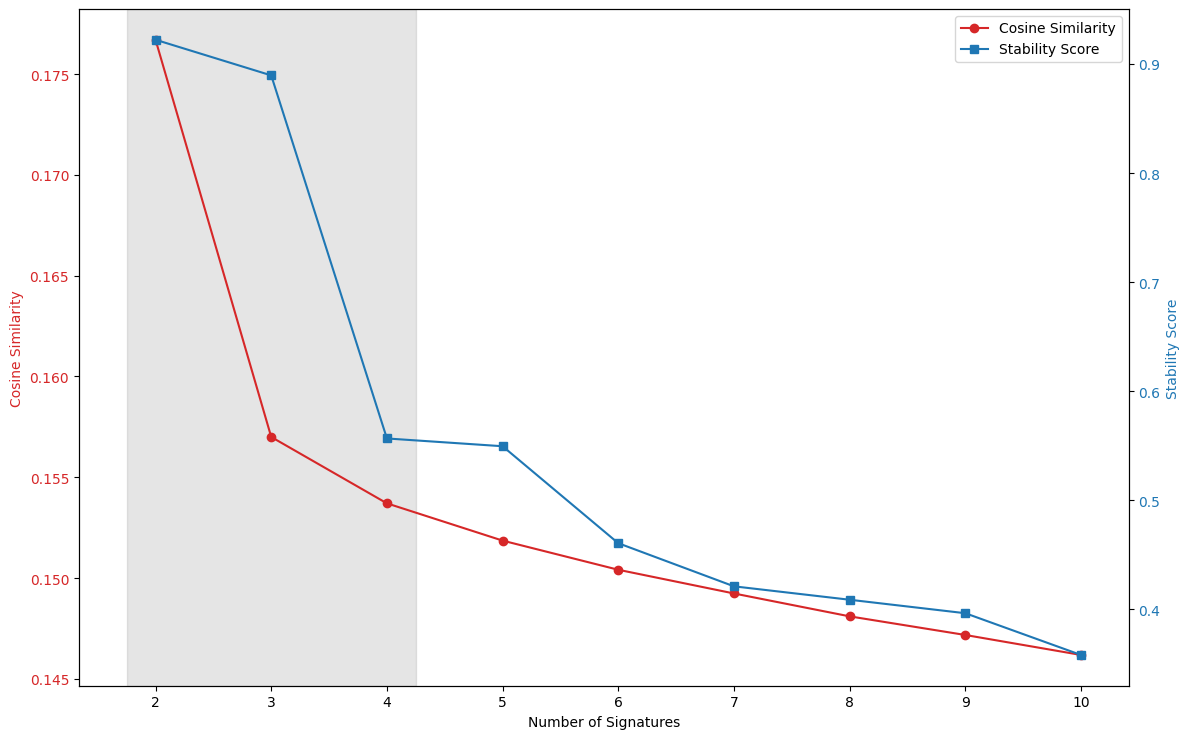

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# set size of figure
plt.figure(figsize=(8, 6))

# assume cos_scores, sil_scores, forbenious are dicts keyed 'dim_2'...'dim_25'
# first, extract the numeric dims and sort
dims_all = sorted(int(d.split('_')[1]) for d in cos_scores)
# pick only the first 10
dims = [d for d in dims_all if 2 <= d <= 10]

# pull out the corresponding y‐values
cos_vals = [cos_scores[f'dim_{d}'] for d in dims]
sil_vals = [sil_scores[f'dim_{d}'] for d in dims]

fig, ax1 = plt.subplots(figsize=(12, 7.5))

# plot cosine similarity
color1 = 'tab:red'
ax1.plot(dims, cos_vals, marker='o', color=color1, label='Cosine Similarity')
ax1.set_xlabel('Number of Signatures')
ax1.set_ylabel('Cosine Similarity', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_xticks(dims)
ax1.grid(True, linestyle='--', alpha=0.5)

# highlight around signature count = 3
ax1.axvspan(1.75, 4.25, color='grey', alpha=0.2)

# secondary axis for silhouette
ax2 = ax1.twinx()
color2 = 'tab:blue'
ax2.plot(dims, sil_vals, marker='s', color=color2, label='Stability Score')
ax2.set_ylabel('Stability Score', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

# unified legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='best')

# remove grid
ax1.grid(False)
# plt.title('Cosine Similarity and Stability vs. Number of Signatures', fontsize=14)
fig.tight_layout()
plt.show()


In [10]:
# now we have determined 3 as the best nuber of dimensions, we can plot the cluster centroids
dim = 'dim_2'
path = os.path.join('/Users/harrisonma/Documents/PhD Classes/2025 Spring/BNFO 285/BNFO285_Projects/project_3/Amy/Output/Signature', dim)
exposure_path = os.path.join('/Users/harrisonma/Documents/PhD Classes/2025 Spring/BNFO 285/BNFO285_Projects/project_3/Amy/Output/Exposure', dim)
files = os.listdir(path)

# filter for only .csv files
csv_files = [f for f in files if f.endswith('.csv')]

# create a list to hold the dataframes
dfs = []

# loop through the csv files and read them into dataframes
count = 1
for file in csv_files:
    df = pd.read_csv(os.path.join(path, file), index_col=0)
    df.columns = [col + '_run_' + str(count) for col in df.columns]  # replace spaces with underscores
    count += 1
    dfs.append(df)

# concatenate the dataframes into one dataframe
combined_df = pd.concat(dfs, axis = 1)


In [11]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from scipy.optimize      import linear_sum_assignment

# pick your dim
dim = 'dim_2'
df  = df_dims[dim]           # contexts × (3×100 run-columns)
k   = 2

# 1) figure out the run-IDs (1…100) from the column names "…_run_{r}"
runs = sorted({c.rsplit('_run_',1)[1] for c in df.columns}, key=int)

# 2) collect each run's 3 signatures as a (3 × contexts) array
per_run = []
for r in runs:
    cols = [c for c in df.columns if c.endswith(f'_run_{r}')]
    # df[cols] is contexts×3 → transpose to 3×contexts
    per_run.append(df[cols].T.values)

# 3) use run#1 as the reference ordering
ref     = per_run[0]    # shape = (3, contexts)
aligned = [ref]

# 4) align runs 2…100 back to that reference
for mat in per_run[1:]:
    # build the 3×3 cost matrix of cosine distances
    cost      = cdist(ref, mat, metric='cosine')
    row_idx, col_idx = linear_sum_assignment(cost)
    # reorder 'mat' so its i-th row best matches ref[i]
    aligned.append(mat[col_idx])

# 5) stack & average to get consensus centroids
aligned_arr = np.stack(aligned, axis=0)  # shape = (100, 3, contexts)
consensus   = aligned_arr.mean(axis=0)   # shape = (3, contexts)

# 6) wrap back into a DataFrame: contexts × 3
centroid_df = pd.DataFrame(
    consensus.T,
    index=df.index,
    columns=[f'Sig{i+1}' for i in range(k)]
)

# 'centroid_df' now holds your 3 consensus signatures for dim_3


In [12]:
centroid_df.to_csv('/Users/harrisonma/Documents/PhD Classes/2025 Spring/BNFO 285/BNFO285_Projects/project_3/Harrison/mut_by_sig_dim2.tsv', sep = '\t')
